GAN is a architecture which makes use of multiple neural networks that compete again each other to make the predictions. This notebook will try to use Needle to build a GAN.

As always, let us start building GAN from hw4.

In [1]:
# Code to set up the assignment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714
%cd /content/drive/MyDrive/10714
!git clone https://github.com/dlsys10714/hw4.git
%cd /content/drive/MyDrive/10714/hw4

!pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
!pip3 install pybind11

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/10714
fatal: destination path 'hw4' already exists and is not an empty directory.
/content/drive/MyDrive/10714/hw4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/dlsys10714/mugrade.git to /tmp/pip-req-build-r_rol82p
  Running command git clone --filter=blob:none --quiet https://github.com/dlsys10714/mugrade.git /tmp/pip-req-build-r_rol82p
  Resolved https://github.com/dlsys10714/mugrade.git to commit 98609ee80ee24bf278455b48aa8d06bd3f5d0430
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!make

-- Found pybind11: /usr/local/lib/python3.8/dist-packages/pybind11/include (found version "2.10.3")
-- Found cuda, building cuda backend
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

-- Configuring done
-- Generating done
-- Build files have been written to: /content/drive/MyDrive/10714/hw4/build
make[1]: Entering directory '/content/drive/MyDrive/10714/hw4/build'
make[2]: Entering directory '/content/drive/MyDrive/10714/hw4/build'
make[3]: Entering directory '/content/drive/MyDrive/10714/hw4/build'
Consolidate compiler generated dependencies of target ndarray_backend_cpu
make[3]: Leaving directory '/content/drive/MyDrive/10714/hw4/build'
[  0%] Built target ndarray_backend_cpu
make[3]: Entering directory '/content/drive/MyDrive/10714/hw4/build'
make[3]: Leaving directory '/content/drive/MyDrive/10714/hw4/build'
[ 50%] Built target ndarray_backend_cuda
make[2]: Leaving directory '/content

In [3]:
import sys
sys.path.append('./python')

Firstly, I will use a very simple GAN to generate LeCunn's MNIST dataset, consisting of about 60,000 black and white images of handwritten digits, each with size 28x28 pixels.

In [4]:
import needle as ndl
import needle.nn as nn
from needle import backend_ndarray as nd
import time
import needle.data as data
import needle.init as init

In [5]:
mnist_dataset = ndl.data.MNISTDataset("../hw0/data/train-images-idx3-ubyte.gz", "../hw0/data/train-labels-idx1-ubyte.gz")
data_loader = data.DataLoader(mnist_dataset)

In [6]:
for i, batch in enumerate(data_loader):
  print("The {} and the data:{}".format(i, batch[0].shape))
  break

The 0 and the data:(1, 28, 28, 1)


Below code show some images in LeCunn's MNIST dataset. We will create a GAN to generate fake MNIST dataset.

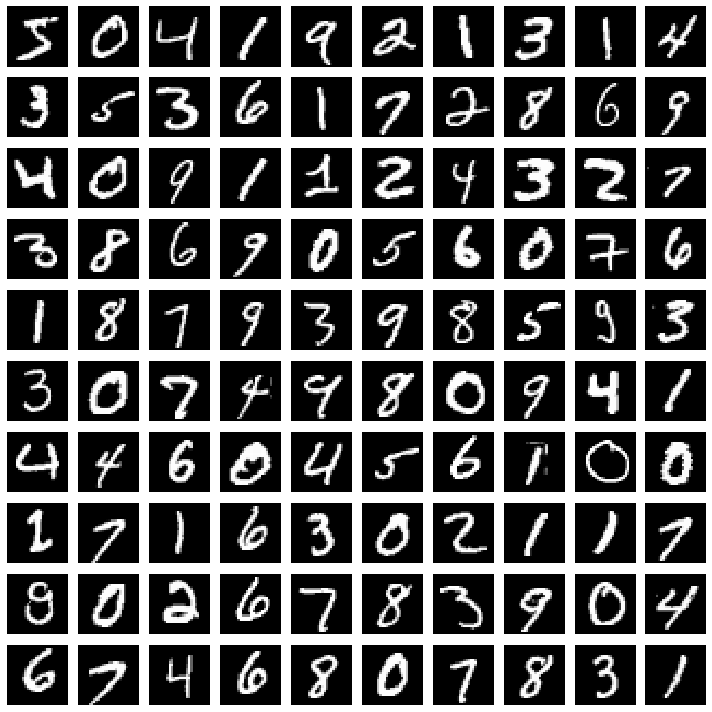

In [7]:
import matplotlib.pyplot as plt
def plot_images(data_loader, dim=(10,10), figsize=(10,10), limit=100):
  plt.figure(figsize=figsize)
  for i, batch in enumerate(data_loader):
    if i >= limit:
      break
    plt.subplot(dim[0],dim[1],i+1)
    image = batch[0].reshape((28,28)).numpy()
    image *= 255
    image.astype('uint8')
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.tight_layout()
plot_images(data_loader)

Discriminator

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
discriminator = nn.DiscriminatorNet()
generator = nn.GeneratorNet()

In [10]:
d_optimizer = ndl.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = ndl.optim.Adam(generator.parameters(), lr=3e-4)

In [11]:
loss = nn.BCELoss()

In [12]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.shape[0]
    # Reset gradients
    optimizer.reset_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)

    # Calculate error and backpropagate
    error_real = loss(prediction_real, init.ones_target(N))
    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, init.zeros_target(N))
    (error_fake + error_real).backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    N = fake_data.shape[0]
    # Reset gradients
    optimizer.reset_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, init.ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [13]:
def plot_fake_images(images, dim=(10,10), figsize=(10,10)):
  plt.figure(figsize=figsize)
  for i in range(images.shape[0]):
    plt.subplot(dim[0],dim[1],i+1)
    image = images[i].reshape((28,28))
    image *= 255
    image.astype('uint8')
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.tight_layout()

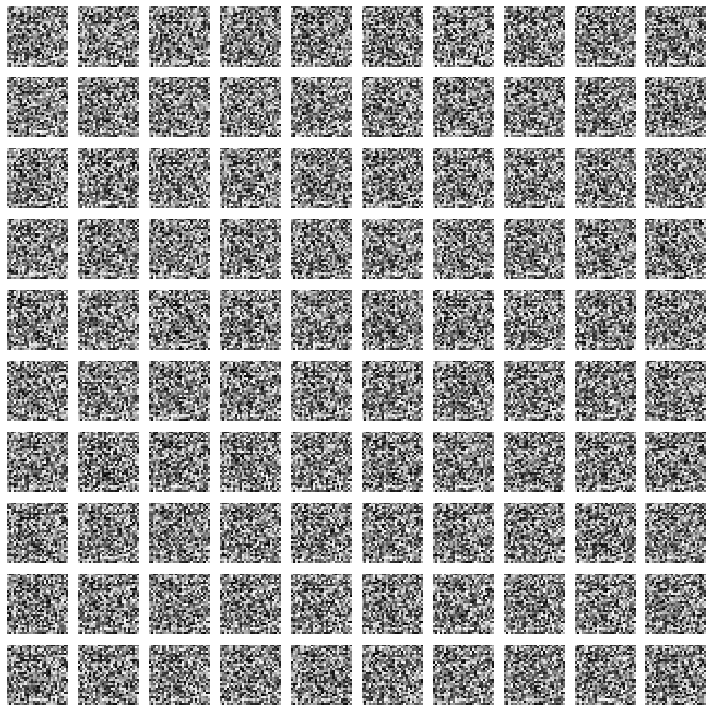

In [14]:
num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

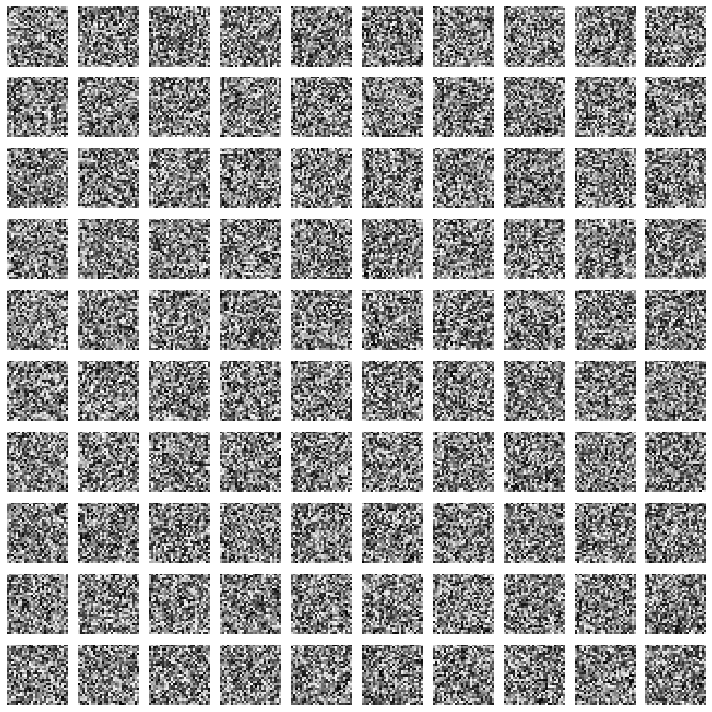

In [15]:
num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

d_error:[1.8087037], g_error:[0.5827268], epoch:0, n_batch:0, num_batches:60000
d_error:[1.8087037], g_error:[0.5827268], epoch:0, n_batch:0, num_batches:60000
d_error:[1.3878472], g_error:[0.91383255], epoch:0, n_batch:1, num_batches:60000
d_error:[0.9438446], g_error:[1.4113991], epoch:0, n_batch:2, num_batches:60000
d_error:[0.73701984], g_error:[1.9258027], epoch:0, n_batch:3, num_batches:60000
d_error:[0.6433769], g_error:[2.4412956], epoch:0, n_batch:4, num_batches:60000
d_error:[0.57954264], g_error:[2.801077], epoch:0, n_batch:5, num_batches:60000
d_error:[0.44712153], g_error:[3.1576812], epoch:0, n_batch:6, num_batches:60000
d_error:[0.44050342], g_error:[3.3030548], epoch:0, n_batch:7, num_batches:60000
d_error:[0.3901853], g_error:[3.6306062], epoch:0, n_batch:8, num_batches:60000
d_error:[0.4750442], g_error:[3.9410815], epoch:0, n_batch:9, num_batches:60000
d_error:[0.47671756], g_error:[4.0018163], epoch:0, n_batch:10, num_batches:60000
d_error:[0.4707024], g_error:[4.16

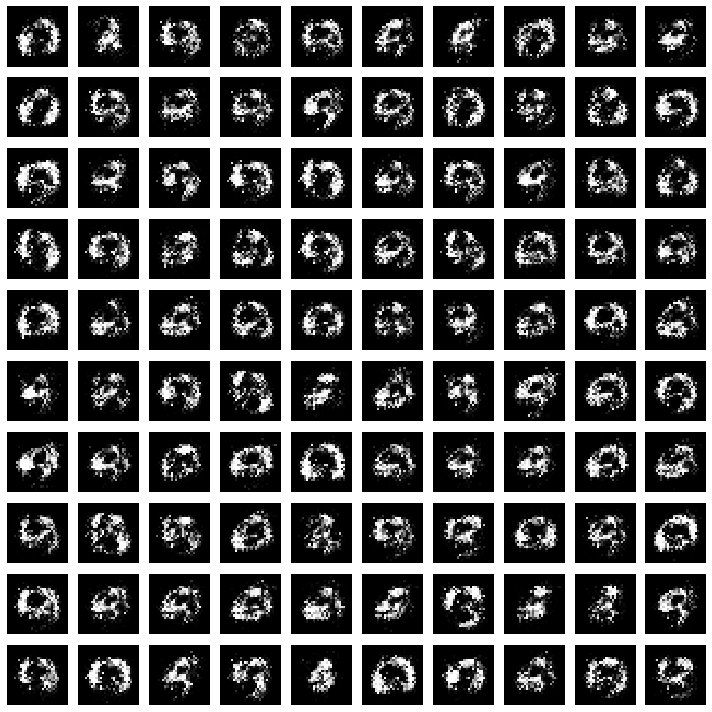

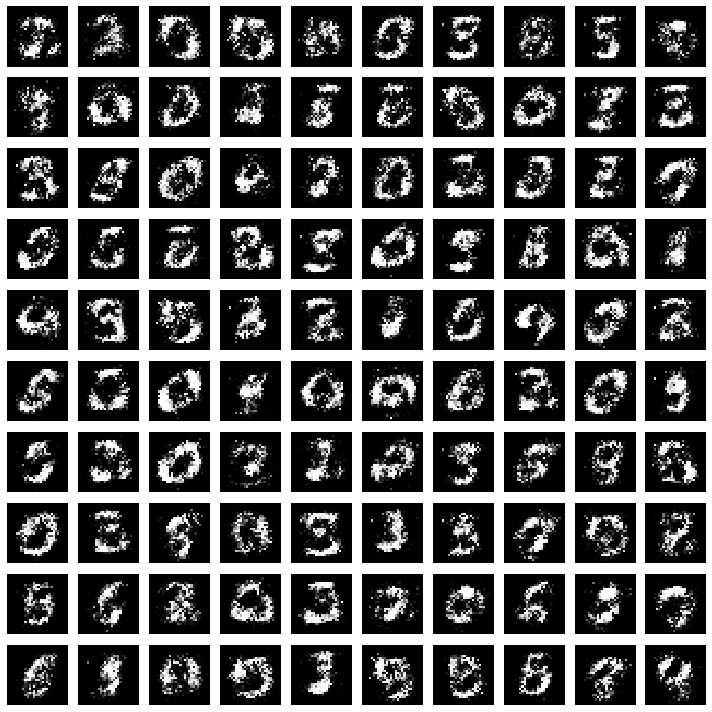

In [16]:
# Total number of epochs to train
data_loader = data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)
num_batches = len(mnist_dataset)
num_epochs = 3
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.shape[0]
        # 1. Train Discriminator
        real_data = real_batch.reshape((N, 784))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(init.noise_v2(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(init.noise_v2(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        if epoch < 1 and n_batch < 100:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
                .format(d_error, g_error, epoch, n_batch, num_batches))
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
              .format(d_error, g_error, epoch, n_batch, num_batches))
      
num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

d_error:[0.5393848], g_error:[2.50448], epoch:0, n_batch:0, num_batches:60000
d_error:[0.5393848], g_error:[2.50448], epoch:0, n_batch:0, num_batches:60000
d_error:[0.42725348], g_error:[2.6708865], epoch:0, n_batch:1, num_batches:60000
d_error:[0.52960604], g_error:[2.5863547], epoch:0, n_batch:2, num_batches:60000
d_error:[0.5025121], g_error:[2.687719], epoch:0, n_batch:3, num_batches:60000
d_error:[0.58028054], g_error:[2.4612098], epoch:0, n_batch:4, num_batches:60000
d_error:[0.53808814], g_error:[2.5754137], epoch:0, n_batch:5, num_batches:60000
d_error:[0.4117248], g_error:[2.6198068], epoch:0, n_batch:6, num_batches:60000
d_error:[0.52889466], g_error:[2.2585921], epoch:0, n_batch:7, num_batches:60000
d_error:[0.44804153], g_error:[2.7595627], epoch:0, n_batch:8, num_batches:60000
d_error:[0.5591731], g_error:[2.5290895], epoch:0, n_batch:9, num_batches:60000
d_error:[0.5320122], g_error:[2.549864], epoch:0, n_batch:10, num_batches:60000
d_error:[0.44607615], g_error:[2.810506

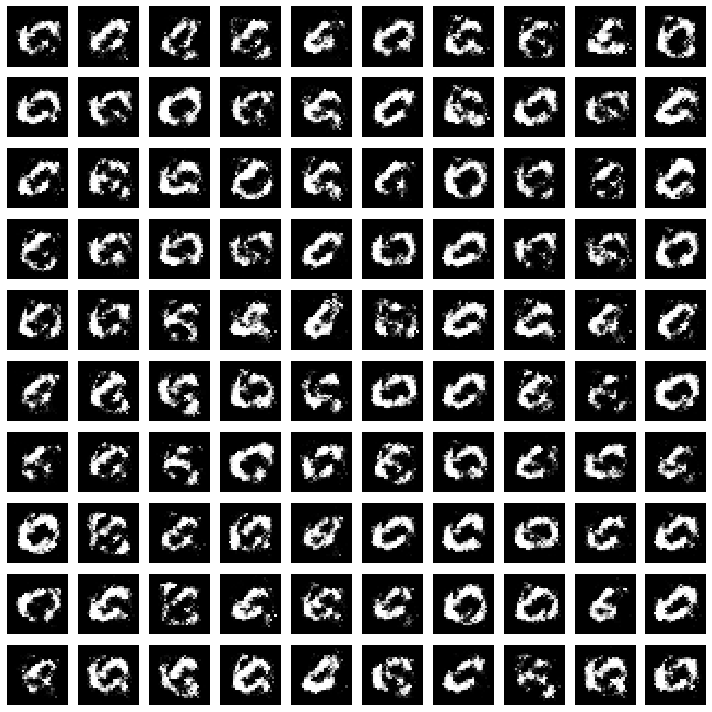

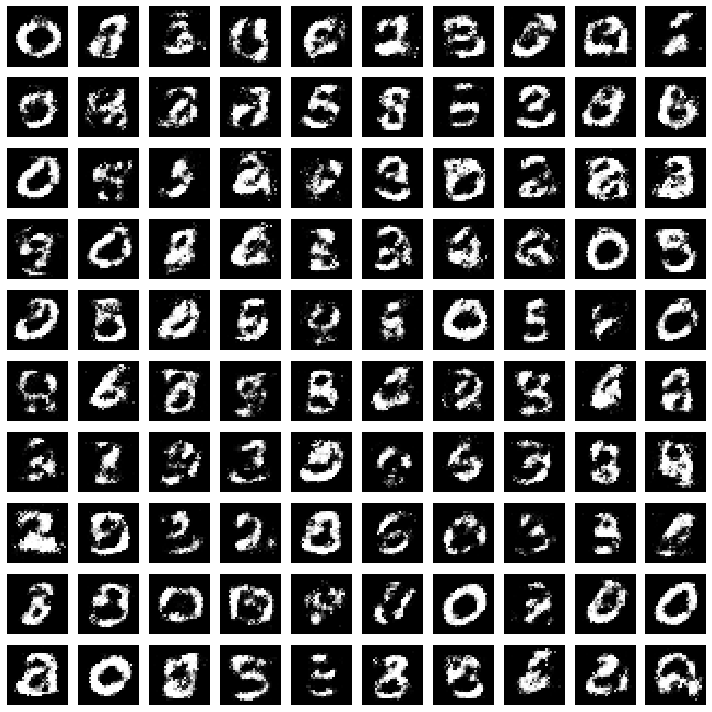

In [17]:
# Total number of epochs to train
data_loader = data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)
num_batches = len(mnist_dataset)
num_epochs = 5
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.shape[0]
        # 1. Train Discriminator
        real_data = real_batch.reshape((N, 784))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(init.noise_v2(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(init.noise_v2(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        if epoch < 1 and n_batch < 100:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
                .format(d_error, g_error, epoch, n_batch, num_batches))
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
              .format(d_error, g_error, epoch, n_batch, num_batches))
          
num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

d_error:[0.50052536], g_error:[3.0425885], epoch:0, n_batch:0, num_batches:60000
d_error:[0.50052536], g_error:[3.0425885], epoch:0, n_batch:0, num_batches:60000
d_error:[0.39713305], g_error:[2.8028724], epoch:0, n_batch:1, num_batches:60000
d_error:[0.45751637], g_error:[2.746634], epoch:0, n_batch:2, num_batches:60000
d_error:[0.470621], g_error:[2.6624098], epoch:0, n_batch:3, num_batches:60000
d_error:[0.36894375], g_error:[2.5873835], epoch:0, n_batch:4, num_batches:60000
d_error:[0.41310486], g_error:[2.1670778], epoch:0, n_batch:5, num_batches:60000
d_error:[0.3871648], g_error:[2.486082], epoch:0, n_batch:6, num_batches:60000
d_error:[0.54575956], g_error:[2.4054275], epoch:0, n_batch:7, num_batches:60000
d_error:[0.3969863], g_error:[2.5928745], epoch:0, n_batch:8, num_batches:60000
d_error:[0.43045738], g_error:[2.835558], epoch:0, n_batch:9, num_batches:60000
d_error:[0.39441025], g_error:[2.6927056], epoch:0, n_batch:10, num_batches:60000
d_error:[0.52924246], g_error:[2.7

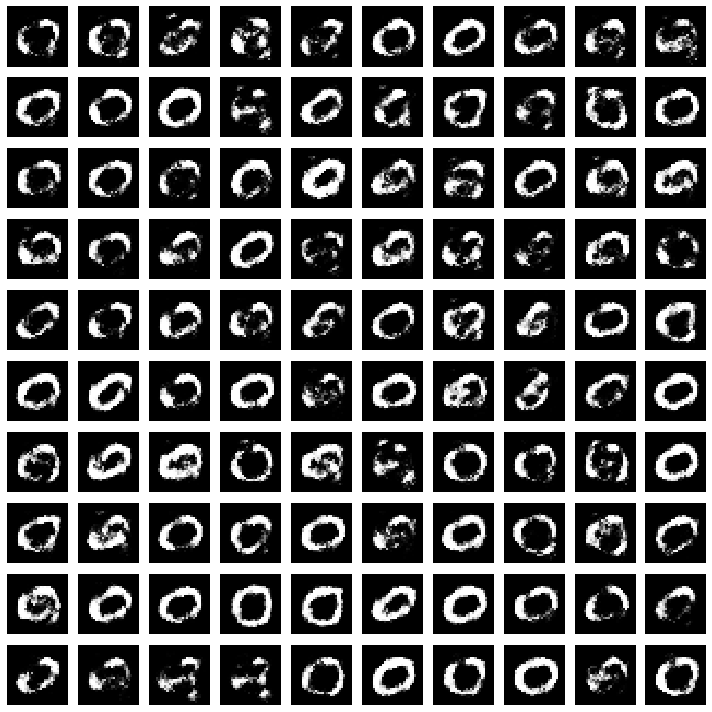

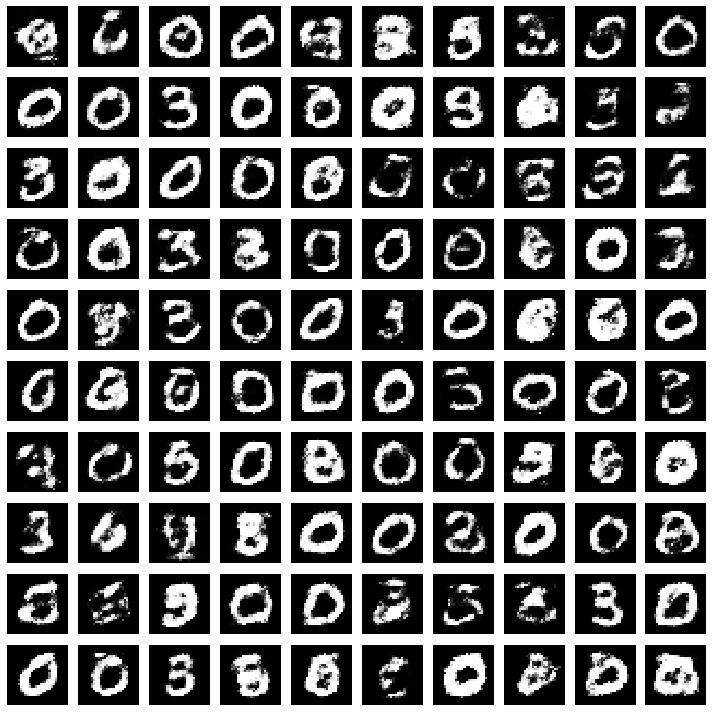

In [18]:
# Total number of epochs to train
data_loader = data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)
num_batches = len(mnist_dataset)
num_epochs = 5
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.shape[0]
        # 1. Train Discriminator
        real_data = real_batch.reshape((N, 784))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(init.noise_v2(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(init.noise_v2(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        if epoch < 1 and n_batch < 100:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
                .format(d_error, g_error, epoch, n_batch, num_batches))
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
              .format(d_error, g_error, epoch, n_batch, num_batches))
        
num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

d_error:[0.38033098], g_error:[2.8419693], epoch:0, n_batch:0, num_batches:60000
d_error:[0.38033098], g_error:[2.8419693], epoch:0, n_batch:0, num_batches:60000
d_error:[0.4176457], g_error:[2.647194], epoch:0, n_batch:1, num_batches:60000
d_error:[0.3490029], g_error:[2.7596154], epoch:0, n_batch:2, num_batches:60000
d_error:[0.40941048], g_error:[2.727332], epoch:0, n_batch:3, num_batches:60000
d_error:[0.41290733], g_error:[2.760731], epoch:0, n_batch:4, num_batches:60000
d_error:[0.46431613], g_error:[2.682642], epoch:0, n_batch:5, num_batches:60000
d_error:[0.4249735], g_error:[3.047204], epoch:0, n_batch:6, num_batches:60000
d_error:[0.3980698], g_error:[2.8445313], epoch:0, n_batch:7, num_batches:60000
d_error:[0.43858173], g_error:[3.155508], epoch:0, n_batch:8, num_batches:60000
d_error:[0.462211], g_error:[2.959766], epoch:0, n_batch:9, num_batches:60000
d_error:[0.4219783], g_error:[2.815177], epoch:0, n_batch:10, num_batches:60000
d_error:[0.4177619], g_error:[2.8593295], 

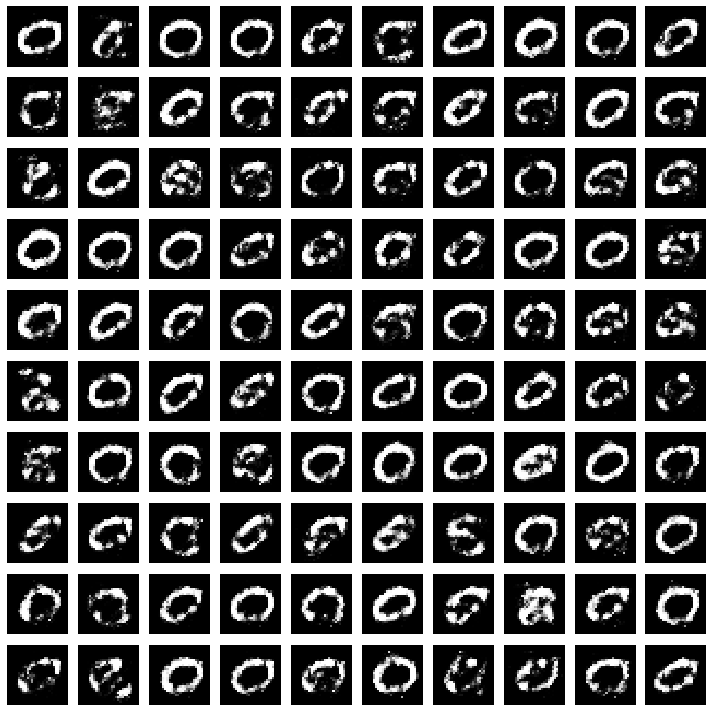

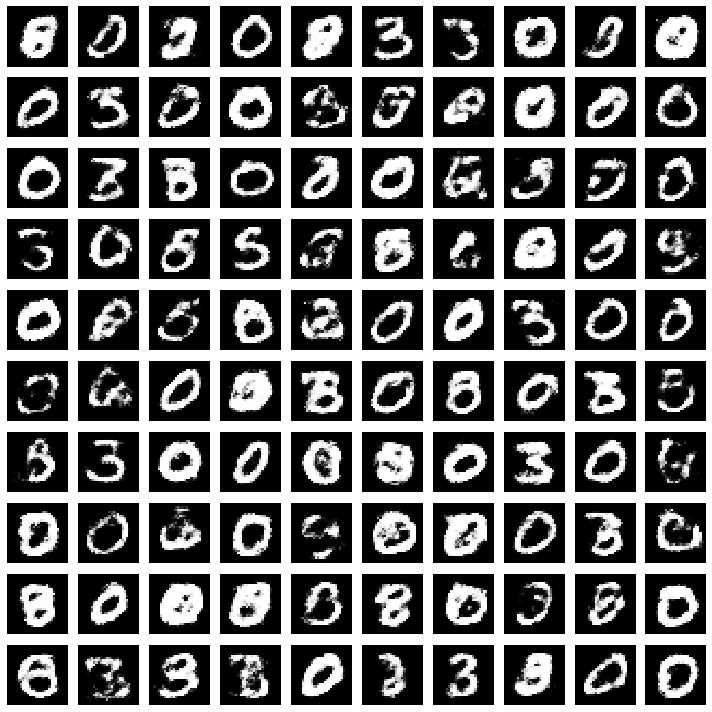

In [19]:
# Total number of epochs to train
data_loader = data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)
num_batches = len(mnist_dataset)
num_epochs = 5
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.shape[0]
        # 1. Train Discriminator
        real_data = real_batch.reshape((N, 784))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(init.noise_v2(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(init.noise_v2(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        if epoch < 1 and n_batch < 100:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
                .format(d_error, g_error, epoch, n_batch, num_batches))
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
              .format(d_error, g_error, epoch, n_batch, num_batches))

num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

d_error:[0.5249445], g_error:[2.4974146], epoch:0, n_batch:0, num_batches:60000
d_error:[0.5249445], g_error:[2.4974146], epoch:0, n_batch:0, num_batches:60000
d_error:[0.41438305], g_error:[2.6619756], epoch:0, n_batch:1, num_batches:60000
d_error:[0.31019557], g_error:[2.58558], epoch:0, n_batch:2, num_batches:60000
d_error:[0.44540134], g_error:[2.866406], epoch:0, n_batch:3, num_batches:60000
d_error:[0.42773947], g_error:[2.9079728], epoch:0, n_batch:4, num_batches:60000
d_error:[0.48936927], g_error:[3.052113], epoch:0, n_batch:5, num_batches:60000
d_error:[0.4854135], g_error:[2.952226], epoch:0, n_batch:6, num_batches:60000
d_error:[0.48753154], g_error:[2.913185], epoch:0, n_batch:7, num_batches:60000
d_error:[0.47515944], g_error:[3.043567], epoch:0, n_batch:8, num_batches:60000
d_error:[0.5050873], g_error:[2.7379596], epoch:0, n_batch:9, num_batches:60000
d_error:[0.62491316], g_error:[2.638191], epoch:0, n_batch:10, num_batches:60000
d_error:[0.4498614], g_error:[2.6579397

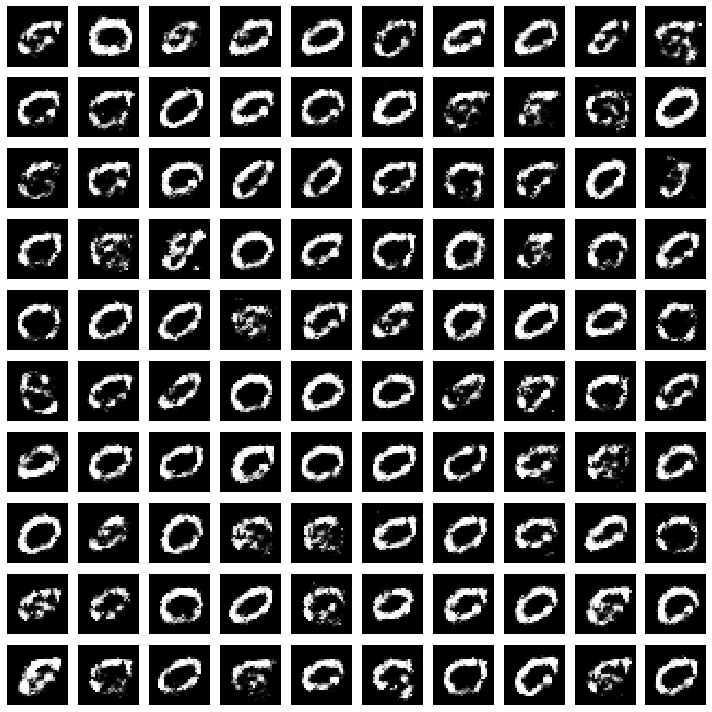

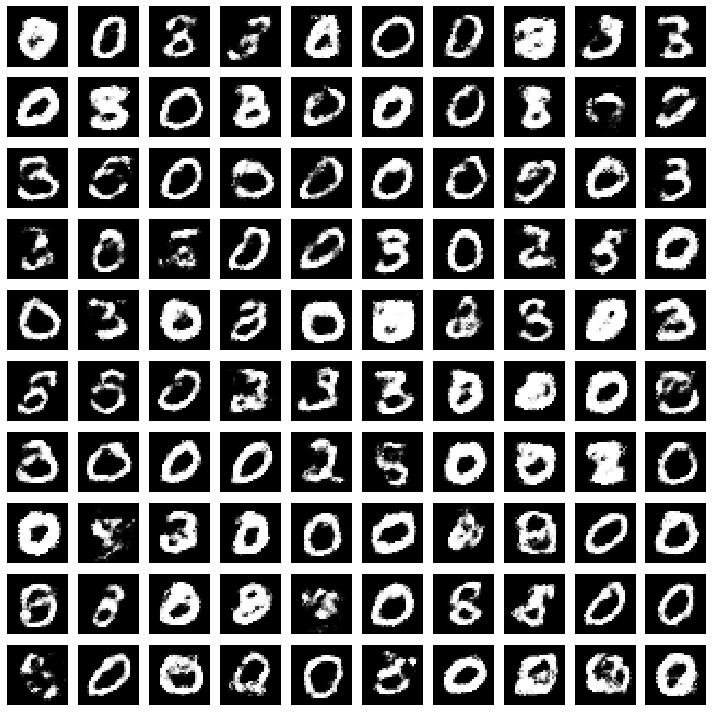

In [20]:
# Total number of epochs to train
data_loader = data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)
num_batches = len(mnist_dataset)
num_epochs = 5
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.shape[0]
        # 1. Train Discriminator
        real_data = real_batch.reshape((N, 784))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(init.noise_v2(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(init.noise_v2(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        if epoch < 1 and n_batch < 100:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
                .format(d_error, g_error, epoch, n_batch, num_batches))
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
              .format(d_error, g_error, epoch, n_batch, num_batches))
          
num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

d_error:[0.4251734], g_error:[2.7854898], epoch:0, n_batch:0, num_batches:60000
d_error:[0.4251734], g_error:[2.7854898], epoch:0, n_batch:0, num_batches:60000
d_error:[0.5093263], g_error:[2.8853137], epoch:0, n_batch:1, num_batches:60000
d_error:[0.51237696], g_error:[2.8840055], epoch:0, n_batch:2, num_batches:60000
d_error:[0.42779964], g_error:[2.9227645], epoch:0, n_batch:3, num_batches:60000
d_error:[0.43668008], g_error:[3.124543], epoch:0, n_batch:4, num_batches:60000
d_error:[0.5075125], g_error:[2.727383], epoch:0, n_batch:5, num_batches:60000
d_error:[0.56095195], g_error:[2.8733792], epoch:0, n_batch:6, num_batches:60000
d_error:[0.4296303], g_error:[2.809736], epoch:0, n_batch:7, num_batches:60000
d_error:[0.66414607], g_error:[2.6894631], epoch:0, n_batch:8, num_batches:60000
d_error:[0.49954474], g_error:[2.777052], epoch:0, n_batch:9, num_batches:60000
d_error:[0.4241988], g_error:[2.7279081], epoch:0, n_batch:10, num_batches:60000
d_error:[0.40354666], g_error:[2.8037

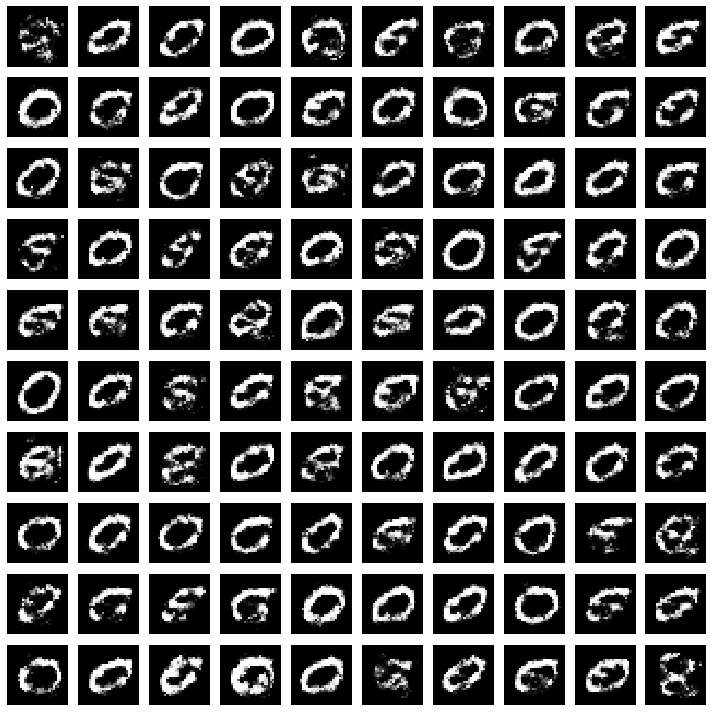

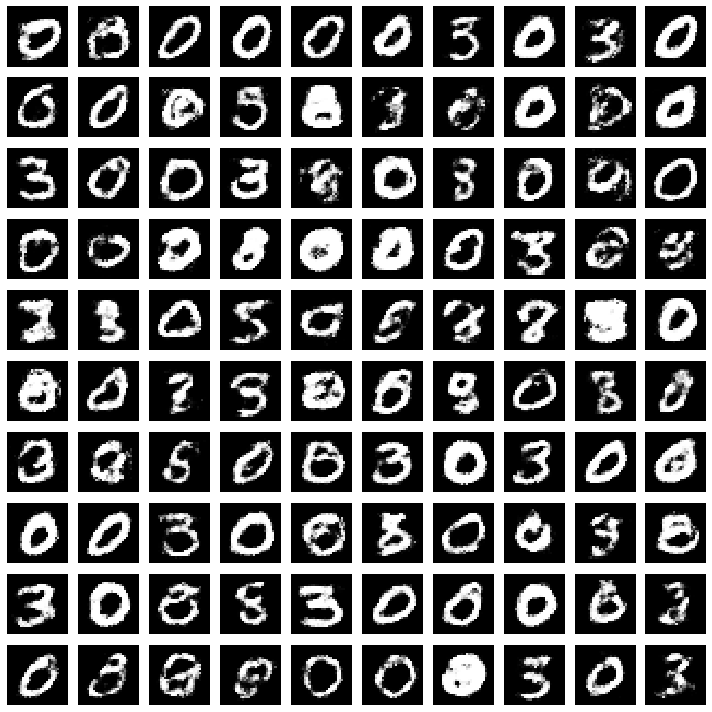

In [21]:
# Total number of epochs to train
data_loader = data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)
num_batches = len(mnist_dataset)
num_epochs = 5
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.shape[0]
        # 1. Train Discriminator
        real_data = real_batch.reshape((N, 784))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(init.noise_v2(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(init.noise_v2(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        if epoch < 1 and n_batch < 100:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
                .format(d_error, g_error, epoch, n_batch, num_batches))
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
              .format(d_error, g_error, epoch, n_batch, num_batches))
          
num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

d_error:[0.47653496], g_error:[2.4968412], epoch:0, n_batch:0, num_batches:60000
d_error:[0.47653496], g_error:[2.4968412], epoch:0, n_batch:0, num_batches:60000
d_error:[0.3423329], g_error:[2.4539294], epoch:0, n_batch:1, num_batches:60000
d_error:[0.6045418], g_error:[2.6012714], epoch:0, n_batch:2, num_batches:60000
d_error:[0.48957676], g_error:[2.5245767], epoch:0, n_batch:3, num_batches:60000
d_error:[0.36699912], g_error:[2.6189334], epoch:0, n_batch:4, num_batches:60000
d_error:[0.56705153], g_error:[2.566333], epoch:0, n_batch:5, num_batches:60000
d_error:[0.42047313], g_error:[2.8076572], epoch:0, n_batch:6, num_batches:60000
d_error:[0.42442873], g_error:[2.6267636], epoch:0, n_batch:7, num_batches:60000
d_error:[0.4122743], g_error:[2.826453], epoch:0, n_batch:8, num_batches:60000
d_error:[0.4798892], g_error:[2.8739977], epoch:0, n_batch:9, num_batches:60000
d_error:[0.38230056], g_error:[2.9941638], epoch:0, n_batch:10, num_batches:60000
d_error:[0.495154], g_error:[2.91

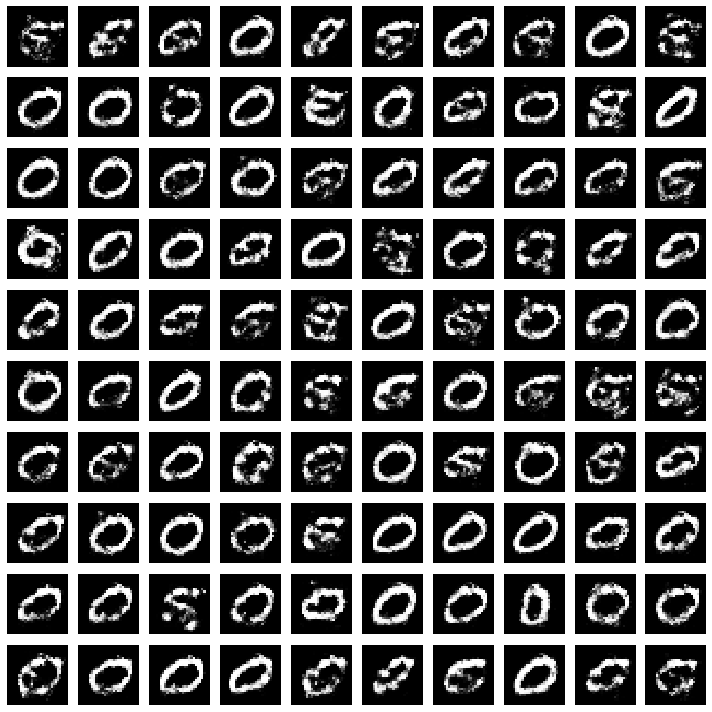

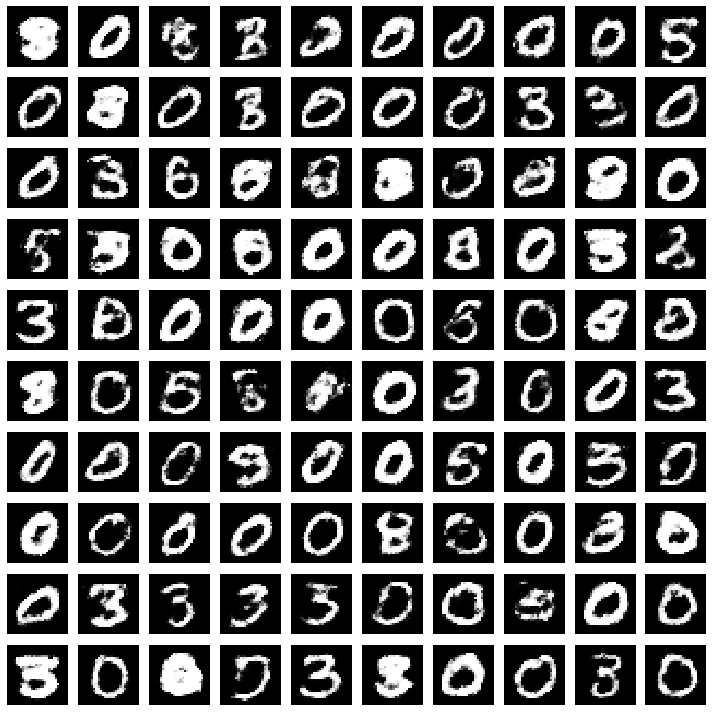

In [22]:
# Total number of epochs to train
data_loader = data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)
num_batches = len(mnist_dataset)
num_epochs = 5
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.shape[0]
        # 1. Train Discriminator
        real_data = real_batch.reshape((N, 784))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(init.noise_v2(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(init.noise_v2(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        if epoch < 1 and n_batch < 100:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
                .format(d_error, g_error, epoch, n_batch, num_batches))
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
              .format(d_error, g_error, epoch, n_batch, num_batches))
        
num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

d_error:[0.3333581], g_error:[2.5487845], epoch:0, n_batch:0, num_batches:60000
d_error:[0.3333581], g_error:[2.5487845], epoch:0, n_batch:0, num_batches:60000
d_error:[0.5302989], g_error:[2.5767224], epoch:0, n_batch:1, num_batches:60000
d_error:[0.4159708], g_error:[2.6340647], epoch:0, n_batch:2, num_batches:60000
d_error:[0.40356135], g_error:[2.926532], epoch:0, n_batch:3, num_batches:60000
d_error:[0.36297336], g_error:[2.8541627], epoch:0, n_batch:4, num_batches:60000
d_error:[0.4452944], g_error:[2.7214718], epoch:0, n_batch:5, num_batches:60000
d_error:[0.4785179], g_error:[3.1592808], epoch:0, n_batch:6, num_batches:60000
d_error:[0.4618595], g_error:[2.826607], epoch:0, n_batch:7, num_batches:60000
d_error:[0.3759173], g_error:[3.0115027], epoch:0, n_batch:8, num_batches:60000
d_error:[0.32574552], g_error:[2.6932986], epoch:0, n_batch:9, num_batches:60000
d_error:[0.43491533], g_error:[3.0298538], epoch:0, n_batch:10, num_batches:60000
d_error:[0.500374], g_error:[2.873713

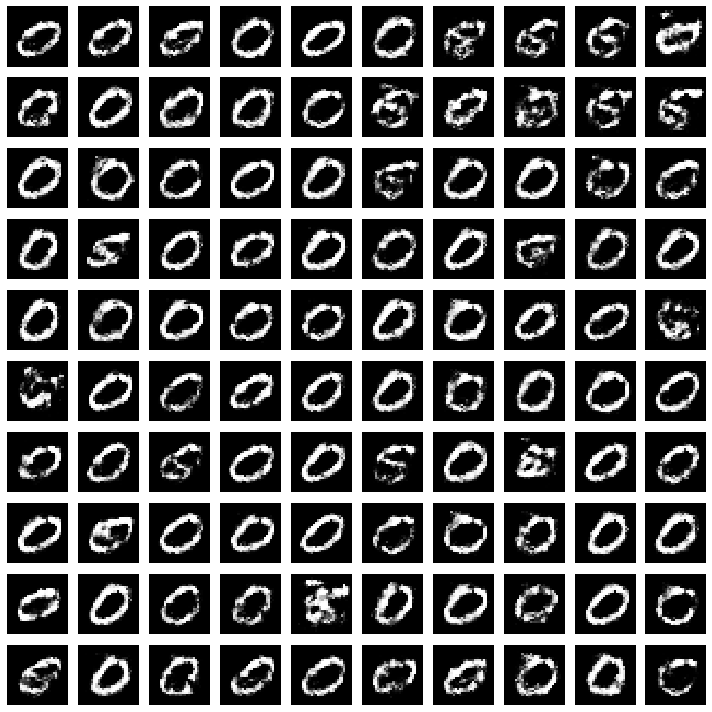

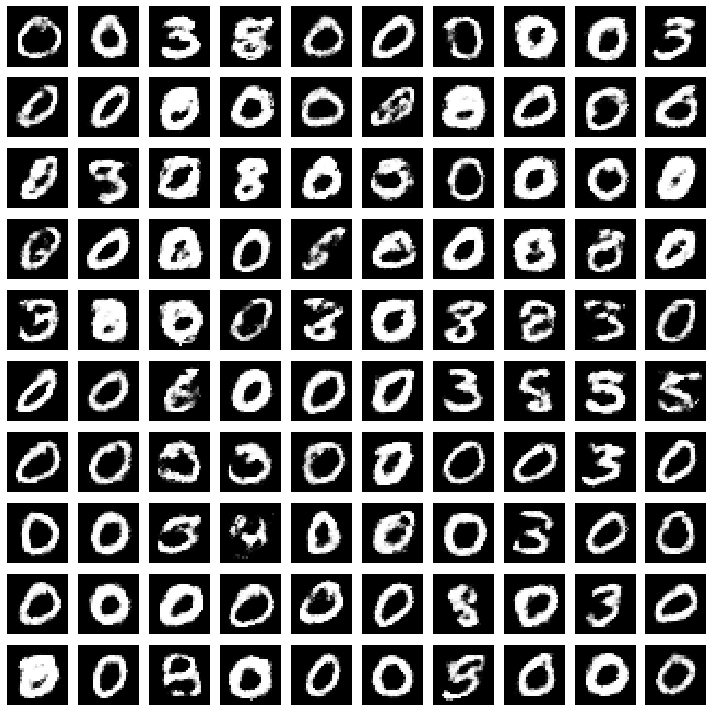

In [23]:
# Total number of epochs to train
data_loader = data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)
num_batches = len(mnist_dataset)
num_epochs = 20
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.shape[0]
        # 1. Train Discriminator
        real_data = real_batch.reshape((N, 784))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(init.noise_v2(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(init.noise_v2(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        if epoch < 1 and n_batch < 100:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
                .format(d_error, g_error, epoch, n_batch, num_batches))
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
              .format(d_error, g_error, epoch, n_batch, num_batches))

num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

d_error:[0.4722454], g_error:[2.6157293], epoch:0, n_batch:0, num_batches:60000
d_error:[0.4722454], g_error:[2.6157293], epoch:0, n_batch:0, num_batches:60000
d_error:[0.24116595], g_error:[2.5565295], epoch:0, n_batch:1, num_batches:60000
d_error:[0.33854008], g_error:[2.8723164], epoch:0, n_batch:2, num_batches:60000
d_error:[0.36133388], g_error:[3.1683319], epoch:0, n_batch:3, num_batches:60000
d_error:[0.32203877], g_error:[2.9810188], epoch:0, n_batch:4, num_batches:60000
d_error:[0.39084685], g_error:[3.1754196], epoch:0, n_batch:5, num_batches:60000
d_error:[0.25140238], g_error:[3.3936117], epoch:0, n_batch:6, num_batches:60000
d_error:[0.40070015], g_error:[3.62483], epoch:0, n_batch:7, num_batches:60000
d_error:[0.33472052], g_error:[3.569422], epoch:0, n_batch:8, num_batches:60000
d_error:[0.5479473], g_error:[3.49596], epoch:0, n_batch:9, num_batches:60000
d_error:[0.4187336], g_error:[3.2445774], epoch:0, n_batch:10, num_batches:60000
d_error:[0.37134585], g_error:[3.318

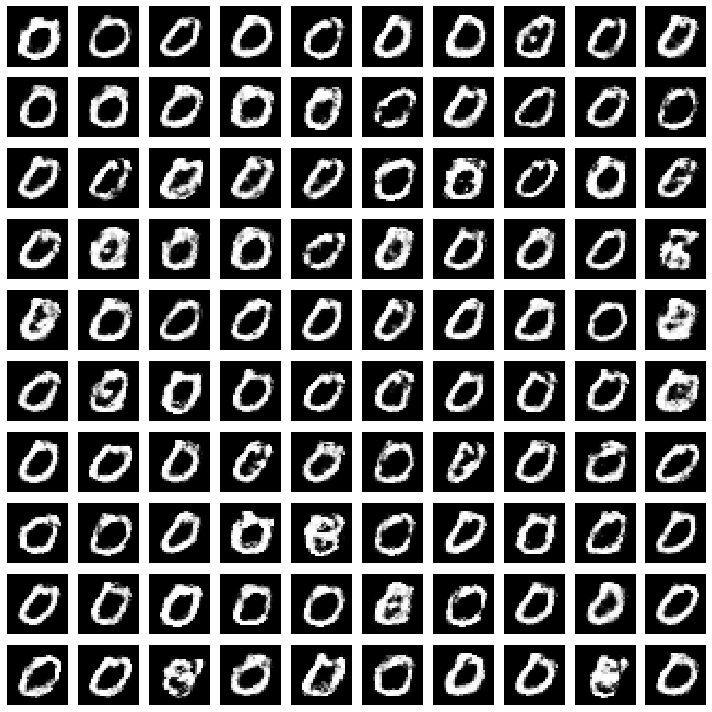

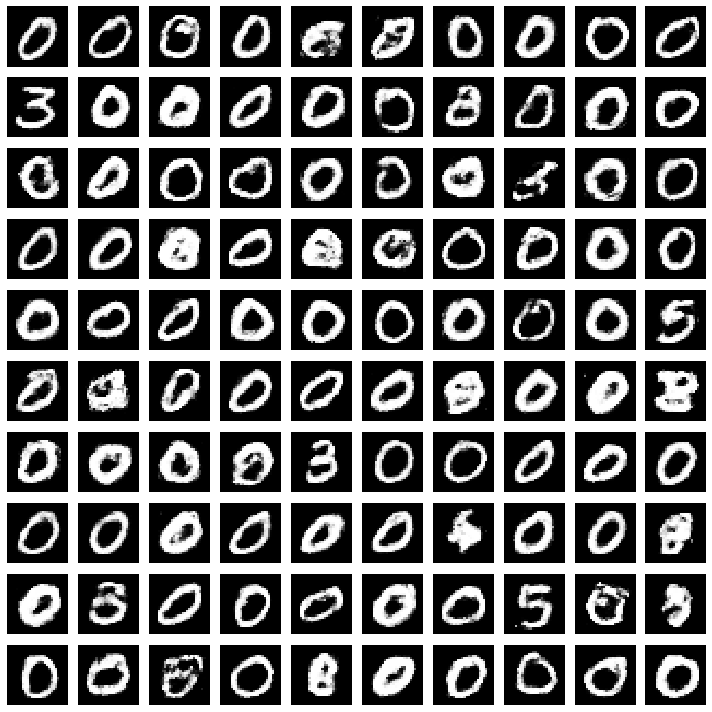

In [24]:
# Total number of epochs to train
data_loader = data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)
num_batches = len(mnist_dataset)
num_epochs = 50
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.shape[0]
        # 1. Train Discriminator
        real_data = real_batch.reshape((N, 784))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(init.noise_v2(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(init.noise_v2(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        if epoch < 1 and n_batch < 100:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
                .format(d_error, g_error, epoch, n_batch, num_batches))
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
          print("d_error:{}, g_error:{}, epoch:{}, n_batch:{}, num_batches:{}" \
              .format(d_error, g_error, epoch, n_batch, num_batches))

num_test_samples = 100
test_noise = init.noise(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

num_test_samples = 100
test_noise = init.noise_v2(num_test_samples)
generated_data = generator(test_noise).detach()
plot_fake_images(generated_data.numpy())

Some tips during implementation.
- Avoid overflow in Sigmoid and Tanh.


```
class Tanh(TensorOp):
    def compute(self, a):
        positive = array_api.maximum(a, 0)
        negative_mask = a < 0
        negative = -1 * array_api.maximum(-1 * a, 0)
        positive_mask = a >= 0
        return ((1 - array_api.exp(-2 * positive)) / (1 + array_api.exp(-2 * positive))) * positive_mask + \
        ((1 - array_api.exp(2 * negative) / (1 + array_api.exp(2 * negative)))) * negative_mask

    def gradient(self, out_grad, node):
        out_grad = out_grad.cached_data
        input = node.inputs[0].cached_data
        return Tensor.make_const(out_grad * (1 - (Tanh().compute(input)) ** 2))


def tanh(a):
    return Tanh()(a)

class Sigmoid(TensorOp):
    def compute(self, a):
        positive = array_api.maximum(a, 0)
        negative_mask = a < 0
        negative = -1 * array_api.maximum(-1 * a, 0)
        positive_mask = a >= 0
        return array_api.power((1 + array_api.exp(-1 * positive)), -1) * positive_mask + \
        (array_api.exp(negative) / (1 + array_api.exp(negative))) * negative_mask

    def gradient(self, out_grad, node):
        out_grad = out_grad.cached_data
        x = node.inputs[0].cached_data
        sx = Sigmoid().compute(x)
        return Tensor.make_const(out_grad * sx * (1 - sx))
```


- Generator and Discriminator network structure is important.


```
class DiscriminatorNet(Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self, input_size=784, device=None, dtype="float32"):
        super().__init__()
        self.input_size=input_size
        
        self.model = Sequential(
            Linear(input_size, 200, device=device, dtype=dtype),
            LeakyReLU(0.02),
            LayerNorm1d(200),
            Linear(200, 1, device=device, dtype=dtype),
            Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

class GeneratorNet(Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, input_size=100, output_size=784, device=None, dtype="float32"):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.model = Sequential(
            Linear(input_size, 200, device=device, dtype=dtype),
            LeakyReLU(0.02),
            LayerNorm1d(200),
            Linear(200, output_size, device=device, dtype=dtype),
            Sigmoid(),
        )

    def forward(self, x):
        x = self.model(x)
        return x
```


- BCELoss function


```
class BCELoss(Module):
    def forward(self, p: Tensor, y: Tensor):
        return -1 * ops.summation(y * ops.log(p + 1e-12) \
        + (1 - y) * ops.log(1 - p + 1e-12)) / y.shape[0]
```

